In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import os
import zipfile

import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


In [ ]:

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/m2nist.zip \
    -O /tmp/m2nist.zip


local_zip = '/tmp/m2nist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

--2021-09-11 09:39:26--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  92.0MB/s    in 0.2s    

2021-09-11 09:39:26 (92.0 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



In [ ]:
BATCH_SIZE = 32

def read_image_and_annotation(image, annotation):
  

  image = tf.cast(image, dtype=tf.float32)
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  image = image / 127.5
  image -= 1

  return image, annotation


def get_training_dataset(images, annos):
  
  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  training_dataset = training_dataset.map(read_image_and_annotation)

  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(images, annos):
 
  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset


def get_test_dataset(images, annos):
  
  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  test_dataset = test_dataset.map(read_image_and_annotation)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset


def load_images_and_segments():
 
  #Loads images and segmentation masks.
  images = np.load('/tmp/training/combined.npy')
  segments = np.load('/tmp/training/segmented.npy')

  #Makes training, validation, test splits from loaded images and segmentation masks.
  train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
  val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)

  return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)

In [ ]:

train_slices, val_slices, test_slices = load_images_and_segments()

training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

In [ ]:

n_classes = 11



colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

def fuse_with_pil(images):
  

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(n_classes):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
  

  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):
 
  ds = dataset.unbatch()

  plt.figure(figsize=(20, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())


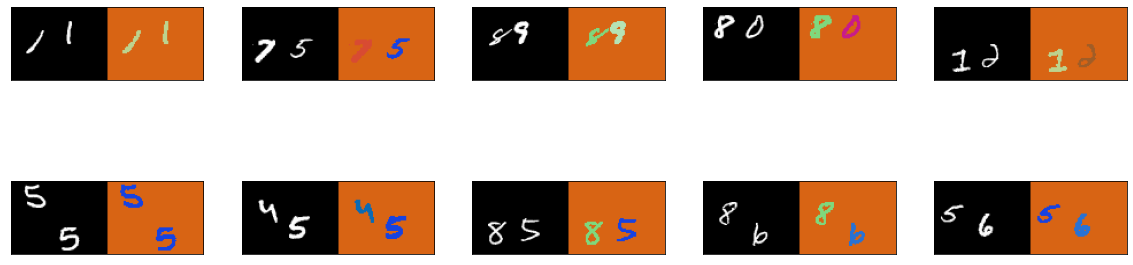

In [ ]:
list_show_annotation(training_dataset, 10)

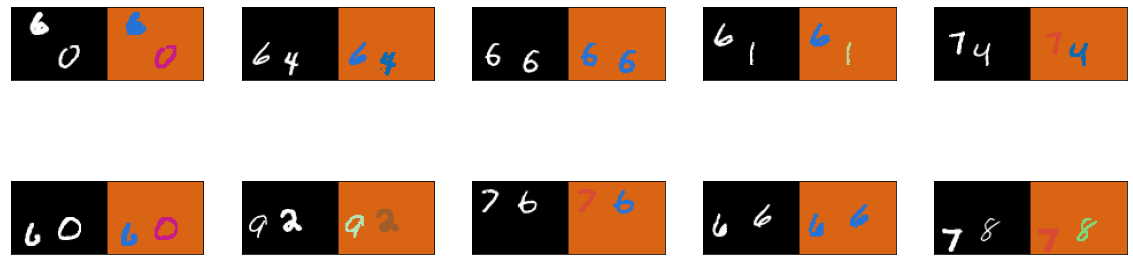

In [ ]:
list_show_annotation(validation_dataset, 10)

In [ ]:
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, strides, pooling_size, pool_strides):
  x = tf.keras.layers.Conv2D(filters, strides, padding='same', data_format=IMAGE_ORDERING)(input)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Conv2D(filters, strides,padding='same')(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=pooling_size,strides=pool_strides)(x)
  x = tf.keras.layers.BatchNormalization()(x)
 
  return x

In [ ]:
test_input = tf.keras.layers.Input(shape=(64,84, 1))
test_output = conv_block(test_input, 32, 3, 2, 2)
test_model = tf.keras.Model(inputs=test_input, outputs=test_output)

print(test_model.summary())

del test_input, test_output, test_model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 84, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 84, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 84, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 84, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 84, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 42, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 42, 32)        128   

In [ ]:
def FCN8(input_height=64, input_width=84):
    
   
    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 1))
    print(img_input[0])


    
    x = tf.keras.layers.ZeroPadding2D(padding=((0,0), (6,6)))(img_input)


    x = conv_block(x, 32, strides=(3,3), pooling_size=(2,2), pool_strides=(2,2))
    
    
    x = conv_block(x, 64, strides=(3,3), pooling_size=(2,2), pool_strides=(2,2))

   
    x = conv_block(x, 128, strides=(3,3), pooling_size=(2,2), pool_strides=(2,2))

    f3 = x

 
    x = conv_block(x, 256, strides=(3,3), pooling_size=(2,2), pool_strides=(2,2))
    
    f4 = x

   
    x = conv_block(x, 256, strides=(3,3), pooling_size=(2,2), pool_strides=(2,2))
  
    f5 = x

    
    return (f3, f4, f5), img_input

In [ ]:
test_convs, test_img_input = FCN8()
test_model = tf.keras.Model(inputs=test_img_input, outputs=[test_convs, test_img_input])

print(test_model.summary())

del test_convs, test_img_input, test_model

KerasTensor(type_spec=TensorSpec(shape=(64, 84, 1), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 84, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 64, 96, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 96, 32)        320       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 96, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 96, 32)        9248      
_________________________________________________________________
l

In [ ]:
def fcn8_decoder(convs, n_classes):
  # features from the encoder stage
  f3, f4, f5 = convs

  # number of filters
  n = 512

  # add convolutional layers on top of the CNN extractor.
  o = tf.keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING)(f5)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o)

    
  
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  o = tf.keras.layers.Add()([o, o2])

  o =  (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  o2 = f3
  o2 = tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o2)


  o = tf.keras.layers.Add()([o, o2])

  
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(o)

  o = (tf.keras.layers.Activation('sigmoid'))(o)
 

  return o

In [ ]:
test_convs, test_img_input = FCN8()
test_fcn8_decoder = fcn8_decoder(test_convs, 11)

print(test_fcn8_decoder.shape)

del test_convs, test_img_input, test_fcn8_decoder

KerasTensor(type_spec=TensorSpec(shape=(64, 84, 1), dtype=tf.float32, name=None), name='tf.__operators__.getitem_1/strided_slice:0', description="created by layer 'tf.__operators__.getitem_1'")
(None, 64, 84, 11)


In [ ]:
convs, img_input = FCN8()

dec_op = fcn8_decoder(convs, n_classes)
model = tf.keras.Model(inputs = img_input, outputs = dec_op)

KerasTensor(type_spec=TensorSpec(shape=(64, 84, 1), dtype=tf.float32, name=None), name='tf.__operators__.getitem_2/strided_slice:0', description="created by layer 'tf.__operators__.getitem_2'")


In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
EPOCHS = 10


steps_per_epoch = 4000//BATCH_SIZE
validation_steps = 800//BATCH_SIZE
test_steps = 200//BATCH_SIZE


history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/10
125/125 [==============================] - 251s 2s/step - loss: 0.1328 - accuracy: 0.8568 - val_loss: 0.0545 - val_accuracy: 0.9424
Epoch 2/10
125/125 [==============================] - 249s 2s/step - loss: 0.0322 - accuracy: 0.9425 - val_loss: 0.0516 - val_accuracy: 0.9424
Epoch 3/10
125/125 [==============================] - 249s 2s/step - loss: 0.0297 - accuracy: 0.9426 - val_loss: 0.0400 - val_accuracy: 0.9424
Epoch 4/10
125/125 [==============================] - 249s 2s/step - loss: 0.0277 - accuracy: 0.9428 - val_loss: 0.0303 - val_accuracy: 0.9426
Epoch 5/10
125/125 [==============================] - 249s 2s/step - loss: 0.0258 - accuracy: 0.9434 - val_loss: 0.0273 - val_accuracy: 0.9429
Epoch 6/10
125/125 [==============================] - 249s 2s/step - loss: 0.0243 - accuracy: 0.9446 - val_loss: 0.0241 - val_accuracy: 0.9448
Epoch 7/10
125/125 [==============================] - 249s 2s/step - loss: 0.0228 - accuracy: 0.9472 - val_loss: 0.0393 - val_accuracy: 0.9437

In [ ]:
results = model.predict(test_dataset, steps=test_steps)

print(results.shape)

(192, 64, 84, 11)


In [ ]:
print(results[0,0,0,0])
print(results[0,0,0,10])

0.0001424253
0.9933078


In [ ]:
results = np.argmax(results, axis=3)

print(results.shape)

(192, 64, 84)


In [ ]:
print(results[0,0,0])

# prediction map for image 0
print(results[0,:,:])

10
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


In [ ]:
def class_wise_metrics(y_true, y_pred):
  
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score


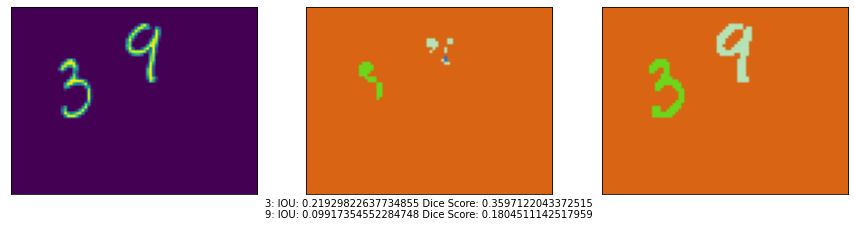

In [ ]:
integer_slider = 105

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image
  
  
iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])  
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)

In [ ]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score)) 
  average_iou += iou

grade = average_iou * 10

print("\nGrade is " + str(grade))

PASSING_GRADE = 60
if (grade>PASSING_GRADE):
  print("You passed!")
else:
  print("You failed. Please check your model and re-train")

Digit 0: IOU: 0.4079055717706484 Dice Score: 0.5794501846564143
Digit 1: IOU: 0.3903886075633681 Dice Score: 0.5615532311466754
Digit 2: IOU: 0.3732032847823353 Dice Score: 0.5435514011918363
Digit 3: IOU: 0.31374984435008096 Dice Score: 0.4776401621654154
Digit 4: IOU: 0.08961433815072117 Dice Score: 0.16448817717067385
Digit 5: IOU: 0.1257515027960062 Dice Score: 0.22340898943271179
Digit 6: IOU: 0.4634732224622394 Dice Score: 0.6333880461201236
Digit 7: IOU: 0.39598332626755717 Dice Score: 0.5673181316947365
Digit 8: IOU: 0.38377779792952127 Dice Score: 0.5546812479630027
Digit 9: IOU: 0.2510940916289999 Dice Score: 0.40139921259169287

Grade is 31.949415877014783
You failed. Please check your model and re-train
